## This code trains an encoder/decoder for 1 channel of the pnnl datasets.

Make sure the channel is set:

channel = 1,2 = velocity_y, volume_frac


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "1"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 1
gridsize = 128
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2
AE = True
numWorkers = 2

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 16
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 500
stack = True
doJacobian = False
createStreamFcn = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 2
    numSamplesToKeep = 2
    
versionName = versionName + '_channel{}_gridsize{}_latentDim{}_filters{}_bz{}_numConv{}_jacobian{}_epochs{}_stack{}'.format(channel,gridsize,latentDim,filters,bz,num_conv,doJacobian,epochs,stack)
versionName

'pnnl_plateau_train_GPUs1_channel1_gridsize128_latentDim16_filters128_bz16_numConv4_jacobianFalse_epochs1000_stackTrue'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Tue Oct 27 14:08:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Tue Oct 27 14:09:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   28C    P2    59W / 250W |    511MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
removeMe = ['041.pkl', '040.pkl', '029.pkl']
for r in removeMe:
    sims.remove(os.path.join(dataDirec,r)) # fix later
numSims = len(sims)
perm = np.random.permutation(numSims)
idx = int(testSplit*numSims)
testInds = perm[:idx]
trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(9, 38)

In [ ]:
testDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE)
trainDataset = CCSI_2D(trainSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE)

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True, num_workers=numWorkers)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz, num_workers=numWorkers)
len(trainDataLoader), len(testDataLoader)

(1187, 282)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [ ]:
X,X = next(iter(trainDataLoader))
X = X.to(device)
X.shape
#X[0].shape, X[1], X[2].shape

torch.Size([16, 1, 128, 128])

In [ ]:
model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device)

if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

[128, 8, 8]


In [ ]:
printNumModelParams(model)

154 layers require gradients (unfrozen) out of 154 layers
8,761,361 parameters require gradients (unfrozen) out of 8,761,361 parameters


In [ ]:
Xhat,z = model(X)
Xhat.shape, z.shape

(torch.Size([16, 1, 128, 128]), torch.Size([16, 16]))

## Loss Function

In [ ]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [ ]:
pred = stream2uv(Xhat,device)
pred.shape

torch.Size([16, 2, 128, 128])

In [ ]:
loss(pred,X,device)

tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)

## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


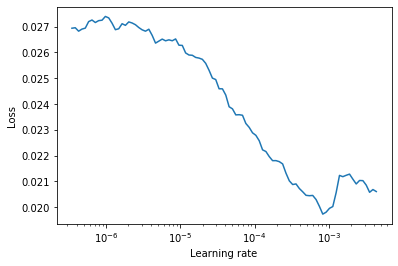

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    model.return_z = False
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)
    model.return_z = True

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(model.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        #X,p = sampleBatch[0],sampleBatch[1]
        X = sampleBatch[0]
        X = X.to(device)
        #p = p.to(device)

        # zero the parameter gradients
        opt.zero_grad()

        X_hat, z = model(X)
        #pl = p_loss(z,p)
        ll = loss(X_hat,X,device)
        combined_loss = ll #pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        #batch_ploss = pl.item()
        #running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            #avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            #tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            #running_ploss = 0.0

    return total_loss, tensorboard_recorder_step, total_steps

In [ ]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        #X,p = sampleBatch[0],sampleBatch[1]
        X = sampleBatch[0]
        X = X.to(device)
        #p = p.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            X_hat, z = model(X)

        # loss
        #combined_loss = p_loss(z,p) + loss(X_hat,X,device)
        combined_loss = loss(X_hat,X,device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, p_loss, loss, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 7.8603e+01
LR: 1.0000e-04


  0%|          | 1/1000 [05:00<83:30:25, 300.93s/it]

valLoss: 6.6055e-02
Better valLoss: 6.6055e-02, Saving models...
--- Epoch 2/1000 ---
trainLoss: 7.0519e+01
LR: 1.0000e-04


  0%|          | 2/1000 [10:05<83:42:36, 301.96s/it]

valLoss: 6.3062e-02
Better valLoss: 6.3062e-02, Saving models...
--- Epoch 3/1000 ---
trainLoss: 6.8813e+01
LR: 1.0000e-04


  0%|          | 3/1000 [15:09<83:49:49, 302.70s/it]

valLoss: 6.2635e-02
Better valLoss: 6.2635e-02, Saving models...
--- Epoch 4/1000 ---
trainLoss: 6.7701e+01
LR: 1.0000e-04


  0%|          | 4/1000 [20:13<83:51:18, 303.09s/it]

valLoss: 6.4453e-02
--- Epoch 5/1000 ---
trainLoss: 6.9335e+01
LR: 1.0000e-04


  0%|          | 5/1000 [25:18<83:56:51, 303.73s/it]

valLoss: 6.2370e-02
Better valLoss: 6.2370e-02, Saving models...
--- Epoch 6/1000 ---
trainLoss: 7.6626e+01
LR: 1.0000e-04


  1%|          | 6/1000 [30:23<83:56:11, 304.00s/it]

valLoss: 6.2244e-02
Better valLoss: 6.2244e-02, Saving models...
--- Epoch 7/1000 ---
trainLoss: 6.7112e+01
LR: 1.0000e-04


  1%|          | 7/1000 [35:28<83:53:53, 304.16s/it]

valLoss: 6.2701e-02
--- Epoch 8/1000 ---


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)

with torch.no_grad():
    X_hat, p = model(X)

if createStreamFcn:
    X_hat = stream2uv(X_hat,device)
    
X.shape, p.shape, X_hat.shape

### Metrics

In [ ]:
RMSE = []
relErr = []
frameRe = []
print('RMSE \t Rel Err')
for idx in range(len(testSimFiles)):
    # testDataset = CCSI_2D([testSimFiles[idx]],doPreprocess=preprocess,channel=channel,AE=False)
    # simDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    # for X,Y in simDataLoader:
    #     p = X[1]
    #     t = X[2]
    #     print(X[0].shape, p, t)

    testDataset = CCSI_2D([testSimFiles[idx]],doPreprocess=preprocess,channel=channel,AE=AE)
    simDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    XX = []
    Real_X = []
    model.eval()
    for i, sampleBatch in enumerate(simDataLoader,start=1):
        with torch.no_grad():
            X,p = sampleBatch
            X = X.to(device)
            p = p.to(device)
            Real_X.append(X)

            X_hat,_ = model(X)

            if createStreamFcn:
                X_hat = stream2uv(X_hat,device)

            XX.append(X_hat)

            #X = X.detach().cpu().squeeze()
            #X_hat = X_hat.detach().cpu().squeeze()
            #plotSampleWprediction(X, X_hat)

    Real_X = torch.cat(Real_X,axis=0).to('cpu')
    Real_X_img = torch.rot90(convertSimToImage(Real_X),1,dims=[2,3])

    Surr_X = torch.cat(XX,axis=0).to('cpu')
    Surr_X_img = torch.rot90(convertSimToImage(Surr_X),1,dims=[2,3])
    Real_X_img.shape, Surr_X_img.shape
    
    r = rmse(Real_X,Surr_X)
    RMSE.append(r)
    
    rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
    print('{}\t{}'.format(r, rel_error))
    relErr.append(rel_error)
    
    re = []
    for x,y in zip(Real_X, Surr_X):
        x = x.squeeze()
        y = y.squeeze()
        e = torch.norm(x - y)/torch.norm(x)
        re.append(e)
    frameRe.append(re)
    #plt.plot(re)
    
np.mean(relErr)
frameRe = np.vstack(frameRe)
plt.plot(frameRe.T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()

### Make Movie

In [ ]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
Xrgb = torch.cat([Surr_X_img, Real_X_img], dim=3)
Xrgb.shape

In [ ]:
try:
    gif = True
    outGif = '{}.gif'.format(versionName)
    create_1_channel_movie(Xrgb.detach().numpy(),outfile=outGif)
except:
    gif = False
    outGif = '{}.mp4'.format(versionName)
    create_1_channel_movie(Xrgb.detach().numpy(),outfile=outGif)

In [ ]:
from IPython.display import Image, Video
if gif:
    Image(filename=outGif)
else:
    Video(filename=outGif)

In [ ]:
versionName